# PSF Contamination Modeling Part 2: Coefficient Fitting and Contamination Evaluation

This notebook will use the tau and rho statistics measured in previous notebook 1 and fit the best-fitting coefficients $\alpha,\beta,\eta$ for each tomography bin, and evaluate the corresponding contamination level due to PSF uncertainty.


The observed shape of a galaxy $\epsilon^\mathrm{obs}$ can be expanded as 
$$\epsilon^\mathrm{obs} = R\gamma + \epsilon^\mathrm{int} + \delta \epsilon^\mathrm{sys}_\mathrm{PSF} + \delta\epsilon^\mathrm{noise} \tag{1}$$ 
where $R$ is the shear response, $\epsilon^\mathrm{int}$ is the intrinsic shape, $\delta\epsilon^\mathrm{noise}$ is the shape bias due to image noise, and 
$$\delta \epsilon^\mathrm{sys}_\mathrm{PSF} = \alpha\epsilon_\mathrm{model}+\beta(\epsilon_*-\epsilon_\mathrm{model})+\eta(\epsilon_*\frac{T_*-T_\mathrm{model}}{T_*})\tag{2}$$
is the shape bias due to PSF misestimation. Here $\epsilon_\mathrm{model}$ and $T_\mathrm{model}$ are the shape and size of the PSF modeled by `PIFF`, and $\epsilon_*$ and $T_*$ are observed shape and size of the PSF.

The two-point correlation functions of $p\equiv\epsilon_*$, $q\equiv(\epsilon_*-\epsilon_\mathrm{model})$, and $w\equiv(\epsilon_*\frac{T_*-T_\mathrm{model}}{T_*})$ can be measured from a reserved star shape catalog. The resulting 2PCFs are called "rho statistics":

$$\rho_0=\langle pp\rangle \tag{3}$$
$$\rho_1=\langle qq\rangle$$
$$\rho_2=\langle qp\rangle$$
$$\rho_3=\langle ww\rangle$$
$$\rho_4=\langle wq\rangle$$
$$\rho_5=\langle wp\rangle$$

2PCFs of cosmic shear $\gamma$ are estimated as
$$\hat{\xi}^{ij}_\pm = \frac{ \langle\epsilon^\mathrm{obs,i}_1(x)\epsilon^\mathrm{obs,j}_1(x+\theta) \rangle \pm \langle\epsilon^\mathrm{obs,i}_2(x)\epsilon^\mathrm{obs,j}_2(x+\theta) \rangle}{R^i R^j}. \tag{4}$$

Assuming no intrinsic alignment, if $\delta \epsilon^\mathrm{sys}_\mathrm{PSF}$ is not corrected, then it will produce a bias in $\hat{\xi}^{ij}_\pm$:
$$\delta \xi^{ij}_\pm = \frac{(\vec{u}^{i})^\mathrm{T}\cdot \rho \cdot \vec{u}^{j}}{R^i R^j},\tag{5}$$
where $\vec{u}^{i}\equiv(\alpha^i, \beta^i, \eta^i)^\mathrm{T}$ is the coefficients of tomography bin $i$, and $\rho$ is the rho statistics matrix
$$\rho = \begin{bmatrix} \rho_0 & \rho_2 & \rho_5 \\\ \rho_2 & \rho_1 & \rho_4 \\\ \rho_5 & \rho_4 & \rho_3 \end{bmatrix} \tag{6}$$

To measure the coefficients $\vec{u}^i$, one has to measured the 2PCF between galaxy shapes and star PSF catalog (so-called "tau statistics")

$$\tau_0^i(\theta) = \langle \epsilon^\mathrm{obs}(x) p(x+\theta)\rangle = \alpha^i \rho_0 + \beta^i \rho_2 + \eta^i \rho_5 \tag{7}$$
$$\tau_2^i(\theta) = \langle \epsilon^\mathrm{obs}(x) q(x+\theta)\rangle = \alpha^i \rho_2 + \beta^i \rho_1 + \eta^i \rho_4$$
$$\tau_5^i(\theta) = \langle \epsilon^\mathrm{obs}(x) w(x+\theta)\rangle = \alpha^i \rho_5 + \beta^i \rho_4 + \eta^i \rho_3$$
Therefore with rho and tau statistics, the coefficients $(\alpha, \beta, \eta)$ can be determined.

**P.S.** The different definition of $\delta \epsilon^\mathrm{sys}_\mathrm{PSF}$ is whether to absorb $R^i$ in the coefficients $\vec{u}^i$, or include them in Eq. (4). I think for Jefferson et al. (2025), they absorb the $R$ in the $\tau$ statistics

## 1. Sanity Check: Visualize the $\rho$ and $\tau$ Statistics

In [280]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
from getdist import plots, MCSamples, loadMCSamples
import getdist as gd
from scipy.stats import chi2, norm
from scipy.special import erfinv
import emcee
from getdist import plots, MCSamples, loadMCSamples
import getdist as gd
from numba import njit, jit
%matplotlib inline

rhos = h5py.File('/home/jiachuan/2pt_measurements_Y3/Jefferson2025RhoTau/rowe_stats_DESY3.hdf5', 'r')
taus = h5py.File('/home/jiachuan/2pt_measurements_Y3/Jefferson2025RhoTau/tau_stats_DESY3.hdf5', 'r')
def readCovmats(covs_fname, NG=True):
    covs = []
    for ct in range(len(covs_fname)):
        cov_data = np.genfromtxt(covs_fname[ct])
        Ndim = int(np.max(cov_data[:,0]) - np.min(cov_data[:,0])) + 1 
        print(f'Ndim = {Ndim}')
        cov = np.zeros((Ndim, Ndim))
        for line in range(cov_data.shape[0]):
            i, j = int(cov_data[line, 0]), int(cov_data[line, 1])
            if(cov_data.shape[1]==10):
                cg = cov_data[line, 8] if np.isfinite(cov_data[line, 8]) else 0.0
                cng = cov_data[line, 9] if np.isfinite(cov_data[line, 9]) else 0.0
                if(not np.isfinite(cov_data[line, 9])):
                    print("NG is not finite: i,j=%d,%d"%(i,j))
                if(not np.isfinite(cov_data[line, 8])):
                    print("G is not finite: i,j=%d,%d"%(i,j))
                if NG:
                    cov[i, j] = cg + cng
                    cov[j, i] = cg + cng
                else:
                    cov[i, j] = cg
                    cov[j, i] = cg
            elif(cov_data.shape[1]==3):
                cov[i, j] = cov_data[line, 2]
                cov[j, i] = cov_data[line, 2]
            else:
                print("ERROR: FORMAT UNRECOGNIZED")
                exit(-1)
        covs.append(cov)
    return covs
def get_delta_xi_pm_PSF(alphas, betas, etas, rho_stats, Rbins):
    thetas = rho_stats[0]['r_nom'].copy()
    Ntheta = len(thetas)
    Nsrc = len(alphas)
    N_xipm = Nsrc*(Nsrc+1)*Ntheta
    dxipm = np.zeros(N_xipm)
    dxipm_err = np.zeros(N_xipm)
    ct = 0
    for i in range(Nsrc):
        for j in range(i,Nsrc):
            
            ai, bi, ci = alphas[i], betas[i], etas[i]
            aj, bj, cj = alphas[j], betas[j], etas[j]
            delta_xip = ai*aj*rho_stats[0]['xip'] + bi*bj*rho_stats[1]['xip'] + (ai*bj+aj*bi)*rho_stats[2]['xip']+\
                        ci*cj*rho_stats[3]['xip'] + (bi*cj+bj*ci)*rho_stats[4]['xip']+\
                        (ai*cj+aj*ci)*rho_stats[5]['xip']
            delta_xim = ai*aj*rho_stats[0]['xim'] + bi*bj*rho_stats[1]['xim'] + (ai*bj+aj*bi)*rho_stats[2]['xim']+\
                        ci*cj*rho_stats[3]['xim'] + (bi*cj+bj*ci)*rho_stats[4]['xim']+\
                        (ai*cj+aj*ci)*rho_stats[5]['xim']
            delta_xip_var = (ai*aj*rho_stats[0]['sigma_xip'])**2 + (bi*bj*rho_stats[1]['sigma_xip'])**2 + \
                        ((ai*bj+aj*bi)*rho_stats[2]['sigma_xip'])**2+\
                        (ci*cj*rho_stats[3]['sigma_xip'])**2 + ((bi*cj+bj*ci)*rho_stats[4]['sigma_xip'])**2+\
                        ((ai*cj+aj*ci)*rho_stats[5]['sigma_xip'])**2
            delta_xim_var = (ai*aj*rho_stats[0]['sigma_xim'])**2 + (bi*bj*rho_stats[1]['sigma_xim'])**2 + \
                        ((ai*bj+aj*bi)*rho_stats[2]['sigma_xim'])**2+\
                        (ci*cj*rho_stats[3]['sigma_xim'])**2 + ((bi*cj+bj*ci)*rho_stats[4]['sigma_xim'])**2+\
                        ((ai*cj+aj*ci)*rho_stats[5]['sigma_xim'])**2
            
            dxipm[ct:ct+Ntheta] = delta_xip / (Rbins[i]*Rbins[j])
            dxipm[ct+N_xipm//2:ct+Ntheta+N_xipm//2] = delta_xim / (Rbins[i]*Rbins[j])
            dxipm_err[ct:ct+Ntheta] = delta_xip_var**0.5 / (Rbins[i]*Rbins[j])
            dxipm_err[ct+N_xipm//2:ct+Ntheta+N_xipm//2] = delta_xim_var**0.5 / (Rbins[i]*Rbins[j])
            
            ct += Ntheta
    return dxipm, dxipm_err

def get_delta_xi_pm_PSF_Jefferson(alphas, betas, etas, Rbins=[1,1,1,1]):
    thetas = rhos['rowe_statistics'][f'rowe_0_PSF-reserved']['theta'][:].copy()
    Ntheta = len(thetas)
    Nsrc = len(alphas)
    N_xipm = Nsrc*(Nsrc+1)*Ntheta
    dxipm = np.zeros(N_xipm)
    dxipm_err = np.zeros(N_xipm)
    ct = 0
    for i in range(Nsrc):
        for j in range(i,Nsrc):
            
            ai, bi, ci = alphas[i], betas[i], etas[i]
            aj, bj, cj = alphas[j], betas[j], etas[j]
            
            rho_stats = [rhos['rowe_statistics'][f'rowe_{k}_PSF-reserved'] for k in range(6)]
            # xi_plus xi_minus
            delta_xip = ai*aj*rho_stats[0]['xi_plus'][:] + bi*bj*rho_stats[1]['xi_plus'][:] + (ai*bj+aj*bi)*rho_stats[2]['xi_plus'][:]+\
                        ci*cj*rho_stats[3]['xi_plus'][:] + (bi*cj+bj*ci)*rho_stats[4]['xi_plus'][:]+\
                        (ai*cj+aj*ci)*rho_stats[5]['xi_plus'][:]
            delta_xim = ai*aj*rho_stats[0]['xi_minus'][:] + bi*bj*rho_stats[1]['xi_minus'][:] + (ai*bj+aj*bi)*rho_stats[2]['xi_minus'][:]+\
                        ci*cj*rho_stats[3]['xi_minus'][:] + (bi*cj+bj*ci)*rho_stats[4]['xi_minus'][:]+\
                        (ai*cj+aj*ci)*rho_stats[5]['xi_minus'][:]
            delta_xip_var = (ai*aj*rho_stats[0]['xip_err'][:])**2 + (bi*bj*rho_stats[1]['xip_err'][:])**2 + \
                        ((ai*bj+aj*bi)*rho_stats[2]['xip_err'][:])**2+\
                        (ci*cj*rho_stats[3]['xip_err'][:])**2 + ((bi*cj+bj*ci)*rho_stats[4]['xip_err'][:])**2+\
                        ((ai*cj+aj*ci)*rho_stats[5]['xip_err'][:])**2
            delta_xim_var = (ai*aj*rho_stats[0]['xim_err'][:])**2 + (bi*bj*rho_stats[1]['xim_err'][:])**2 + \
                        ((ai*bj+aj*bi)*rho_stats[2]['xim_err'][:])**2+\
                        (ci*cj*rho_stats[3]['xim_err'][:])**2 + ((bi*cj+bj*ci)*rho_stats[4]['xim_err'][:])**2+\
                        ((ai*cj+aj*ci)*rho_stats[5]['xim_err'][:])**2
            
            dxipm[ct:ct+Ntheta] = delta_xip / (Rbins[i]*Rbins[j])
            dxipm[ct+N_xipm//2:ct+Ntheta+N_xipm//2] = delta_xim / (Rbins[i]*Rbins[j])
            dxipm_err[ct:ct+Ntheta] = delta_xip_var**0.5 / (Rbins[i]*Rbins[j])
            dxipm_err[ct+N_xipm//2:ct+Ntheta+N_xipm//2] = delta_xim_var**0.5 / (Rbins[i]*Rbins[j])
            
            ct += Ntheta
    return thetas, dxipm, dxipm_err 

def get_coeffs_by_nsigma(nsigma_min, nsigma_max, tomo_bin):
    ### read the chain
    samp = np.array([
        taus['tau_statistics']['chain_bestfits_PSF-reserved'][f'bin_{tomo_bin}']['alpha'][:],
        taus['tau_statistics']['chain_bestfits_PSF-reserved'][f'bin_{tomo_bin}']['beta'][:],
        taus['tau_statistics']['chain_bestfits_PSF-reserved'][f'bin_{tomo_bin}']['eta'][:]
    ]).T
    bf = {'alpha': taus['tau_statistics']['bestfits_PSF-reserved'][f'bin_{tomo_bin}']['alpha'][()],
          'beta': taus['tau_statistics']['bestfits_PSF-reserved'][f'bin_{tomo_bin}']['beta'][()],
          'eta': taus['tau_statistics']['bestfits_PSF-reserved'][f'bin_{tomo_bin}']['eta'][()],
    }

    samples = MCSamples(samples = samp, 
       names    = ['alpha', 'beta', 'eta'],
       labels   = ['alpha', 'beta', 'eta'],
       settings = {
           'mult_bias_correction_order':0,
           'smooth_scale_2D':0.25 + 0.1, # VM: 0.35
           'smooth_scale_1D':0.25 + 0.1, # VM: 0.35
           'boundary_correction_order':1,
       }
    )

    ### get the param cov and bias
    param_cov = samples.cov(pars=['alpha', 'beta', 'eta'])
    dpar = [(samp[i] - bf_par) for i in range(samp.shape[0])]
    dchi2 = [dp@np.linalg.inv(param_cov)@dp.T for dp in dpar]
    p = [chi2.cdf(_dchi2, 3) for _dchi2 in dchi2]
    nsigma = np.array([erfinv(_p)*np.sqrt(2) for _p in p])
    
    return samp[(nsigma > nsigma_min) & (nsigma < nsigma_max)]

TARGET_DIR = "/home/jiachuan/2pt_measurements_Y3/data_planck"
# we use 30 log-bins from 0.'25 to 250'
thetas_edge = np.logspace(np.log10(0.25), np.log10(250), 31)
thetas = 2/3*(thetas_edge[1:]**3 - thetas_edge[:-1]**3) / ((thetas_edge[1:]**2 - thetas_edge[:-1]**2))

In [141]:
# covariance matrix
covmat_file = "/home/jiachuan/cocoa/Cocoa/projects/desy1xplanck/data/covmats/"+\
"cov_DESY3xPLKR4_mix6x2pt_baseline_8-2048_Ntheta30_withAnnulus_llllY3_kkkkPR4"
covmat = readCovmats([covmat_file])[0][:600,:600]
invcov = np.linalg.inv(covmat)

Ndim = 1809


In [287]:
components = ['p', 'q', 'w']
### read rho statistics measurement
rho_riz_stats = []
for i in range(3):
    for j in range(i+1):
        print(f'Read rho statistics: {components[i]}-{components[i-j]}')
        rho_riz = np.genfromtxt(TARGET_DIR+"/rho_stats_%s%s_riz_Ntheta30_v3.txt"%(components[i], components[i-j]), 
                            names=True, skip_header=1)
        rho_riz_stats.append(rho_riz)
### read tau statistics
tau_riz_stats = []
for i in range(4):
    _tau_riz_stats = []
    for j in range(3):
        print(f'Read tau statistics {components[j]}-S{i+1}')
        tau_riz = np.genfromtxt(TARGET_DIR+"/tau_stats_%s-S%d_riz_Ntheta30_v3.txt"%(components[j], i), 
                            names=True, skip_header=1)
        _tau_riz_stats.append(tau_riz)
    tau_riz_stats.append(_tau_riz_stats)
### read the jacknife covariance
tau_riz_cov = []
for i in range(4):
    data = np.genfromtxt(TARGET_DIR+f'/tau_covmat_S{i}_riz_Ntheta30_v3.txt')
    tau_riz_cov.append(data)

Read rho statistics: p-p
Read rho statistics: q-q
Read rho statistics: q-p
Read rho statistics: w-w
Read rho statistics: w-q
Read rho statistics: w-p
Read tau statistics p-S1
Read tau statistics q-S1
Read tau statistics w-S1
Read tau statistics p-S2
Read tau statistics q-S2
Read tau statistics w-S2
Read tau statistics p-S3
Read tau statistics q-S3
Read tau statistics w-S3
Read tau statistics p-S4
Read tau statistics q-S4
Read tau statistics w-S4


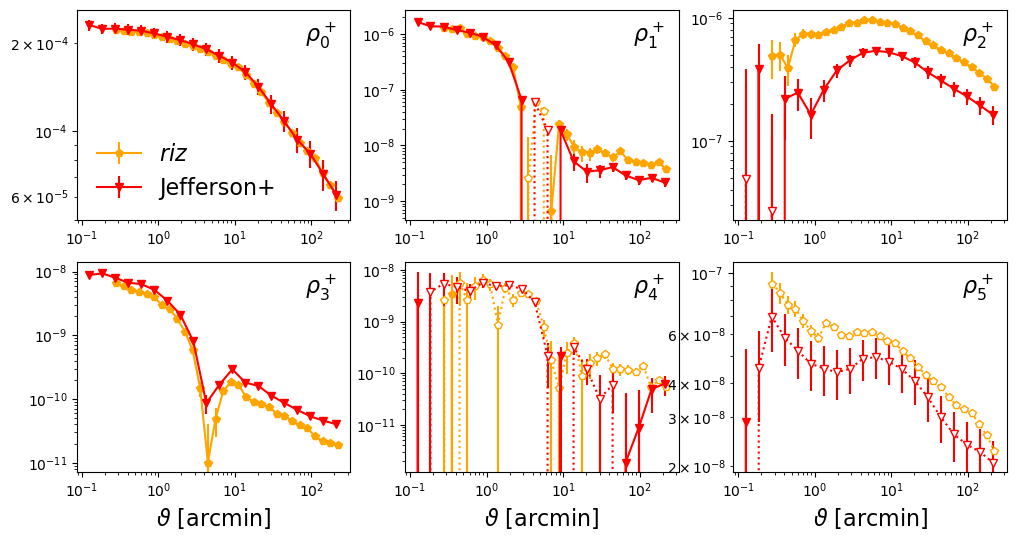

In [285]:
fig, axes = plt.subplots(2,3,figsize=(12,6))

for i in range(6):
    ax = axes[i//3, i%3]
    
    rho_riz = rho_riz_stats[i]
    ax.errorbar(rho_riz['r_nom'], rho_riz['xip'], yerr=rho_riz['sigma_xip'], ls='-', 
                color='orange', marker='p', label='$riz$')
    ax.errorbar(rho_riz['r_nom'], -rho_riz['xip'], yerr=rho_riz['sigma_xip'], ls=':', color='orange', 
                marker='p', mfc='white')
    
    rho_jefferson = rhos['rowe_statistics'][f'rowe_{i}_PSF-reserved']
    ax.errorbar(rho_jefferson['theta'][:], rho_jefferson['xi_plus'][:], yerr=rho_jefferson['xip_err'][:], ls='-',
               color='red', marker='v', label='Jefferson+')
    ax.errorbar(rho_jefferson['theta'][:], -rho_jefferson['xi_plus'][:], yerr=rho_jefferson['xip_err'][:], ls=':',
               color='red', marker='v', mfc='white')
    
    ax.text(0.95, 0.95, r'$\rho^+_'f'{i}'r'$', transform=ax.transAxes, fontsize=16, ha='right', va='top')
    ax.set(xscale='log', yscale='log')
    if i//3==1:
        ax.set_xlabel(r'$\vartheta$ [arcmin]', fontsize=16)
axes[0,0].legend(loc='lower left', fontsize=16, frameon=False)
plt.show()
#plt.savefig('figs/rho_stats_compare.png', 
#            dpi=300, transparent=False, facecolor="white")

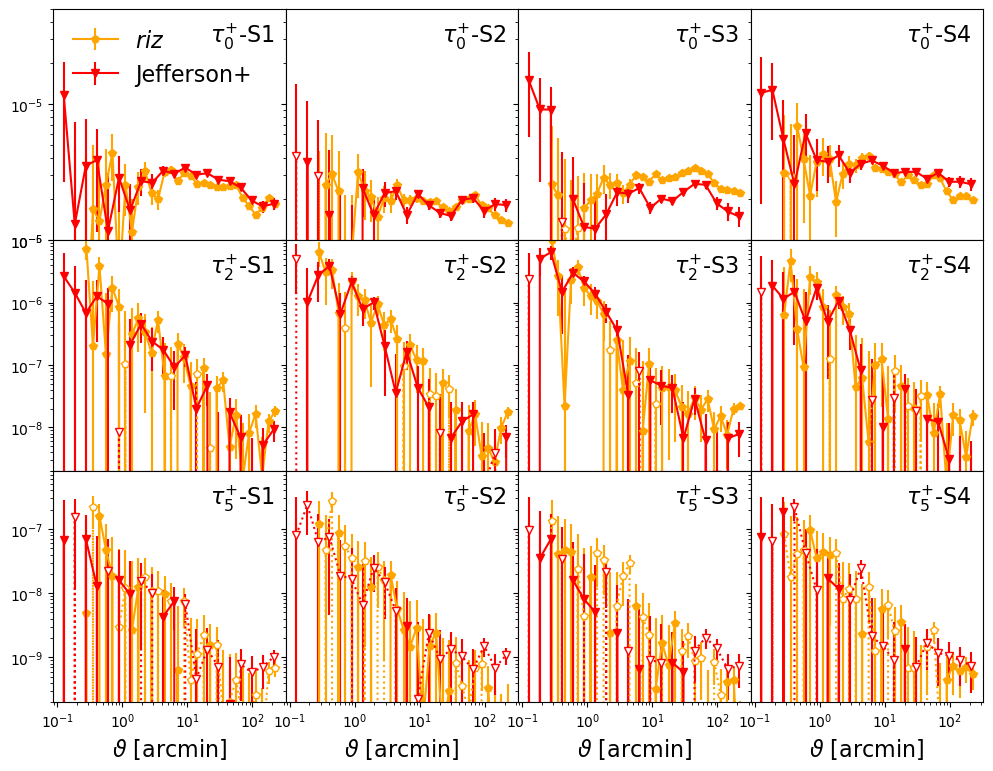

In [286]:
fig, axes = plt.subplots(3,4,figsize=(12,9), sharey=False)

for i in range(4):
    for j in range(3):
        ax = axes[j, i]
        
        ### Tau from riz
        tau_riz = tau_riz_stats[i][j]
        ax.errorbar(tau_riz['r_nom'], tau_riz['xip'], yerr=tau_riz['sigma_xip'], ls='-', 
                    color='orange', marker='p', label='$riz$')
        ax.errorbar(tau_riz['r_nom'], -tau_riz['xip'], yerr=tau_riz['sigma_xip'], ls=':', 
                    color='orange', marker='p', mfc='white')
        ### Tau from Jefferson
        tau_jefferson = taus['tau_statistics']['tau_PSF-reserved'][f'bin_{i}']
        tag = ['tau0p', 'tau2p', 'tau5p'][j]
        tau_err_jefferson = np.diag(taus['tau_statistics']['tau_PSF-reserved'][f'bin_{i}']['cov'][:])**0.5
        ax.errorbar(tau_jefferson['theta'][:], tau_jefferson[tag][:], 
                    yerr=tau_err_jefferson[j*40+20:(j+1)*40], ls='-',
                   color='red', marker='v', label='Jefferson+')
        ax.errorbar(tau_jefferson['theta'][:], -tau_jefferson[tag][:], 
                    yerr=tau_err_jefferson[j*40+20:(j+1)*40], ls=':',
                   color='red', marker='v', mfc='white')

        ax.text(0.95, 0.95, r'$\tau_'f'{[0,2,5][j]}'r'^{+}$-S%d'%(i+1), 
                transform=ax.transAxes, fontsize=16, ha='right', va='top')
        ax.set(xscale='log', yscale='log')
        if j==2:
            ax.set_xlabel(r'$\vartheta$ [arcmin]', fontsize=16)
        else:
            ax.set(xticklabels=[])
        if j==0:
            ax.set(ylim=[1e-6, 5e-5])
        elif j==1:
            ax.set(ylim=[2e-9, 1e-5])
        elif j==2:
            ax.set(ylim=[2e-10, 8e-7])
        if i!=0:
            ax.set(yticklabels=[])
axes[0,0].legend(loc='upper left', fontsize=16, frameon=False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

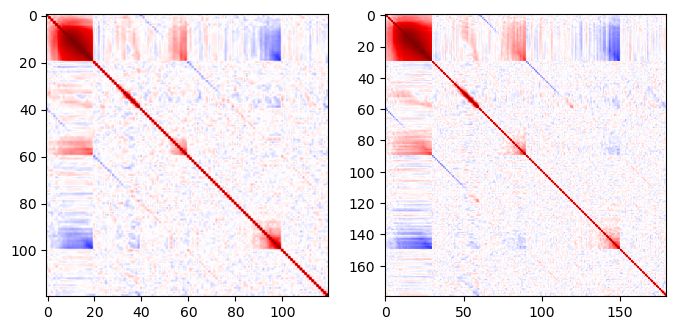

In [288]:
### Show & compare the covariance matrix
test_cov = taus['tau_statistics']['tau_PSF-reserved']['bin_0']['cov'][:]
test_cov_2 = tau_riz_cov[0]

fig, axes = plt.subplots(1,2,figsize=(8,4))

axes[0].imshow(test_cov/np.sqrt(np.outer(np.diag(test_cov), np.diag(test_cov))), 
               cmap='seismic', vmin=-1, vmax=1)
axes[1].imshow(test_cov_2/np.sqrt(np.outer(np.diag(test_cov_2), np.diag(test_cov_2))), 
           cmap='seismic', vmin=-1, vmax=1)
plt.show()

## 2. Run MCMC Fitting

**Note:** Remember to apply the debias factors when inverting a empirical covariance matrix.

In [262]:
### Fit coefficients from tau and rho statistics
### Tau: pm 0 (p), 2 (q), 5 (w), 180 data points in total
def fit_tau_from_rho_stats(taus, rhos, tau_cov, N_JK=1000, Nwalkers=12, Nsteps=30000, Nburns=10000, debias=True):
    #from multiprocessing import Pool
    assert len(taus) == 3, f'taus list length is {len(taus)}, should be 3!'
    assert len(rhos) == 6, f'taus list length is {len(rhos)}, should be 6!'
    ### get initial coeff
    p0_mean = np.array([0.001, 1, 1])
    p0_std = np.array([0.00001, 0.001, 0.001])
    p0 = p0_mean[np.newaxis,:] + np.random.rand(Nwalkers, 3) * p0_std[np.newaxis,:]
    ### prepare dataset
    rhos_p_array = np.array([rho['xip'] for rho in rhos])
    rhos_m_array = np.array([rho['xim'] for rho in rhos])
    taus_array = np.array(np.hstack([np.hstack([tau['xip'], tau['xim']]) for tau in taus]))
    ### debias the inverse covariance
    if debias:
        N_dv = tau_cov.shape[0]
        N_theta = 3
        a = (N_JK - (N_dv - N_theta) - 2)/(N_JK - 1)
        b = (N_dv - N_theta)*(N_JK-N_dv-2)/(N_JK-N_dv-1)/(N_JK-N_dv-4)
    else:
        a = 1; b = 0;
    print(f'Applying debias factor for tau covariance: a = {a:.4f}; b = {b:.4f}')
    eigc, eigv = np.linalg.eig(tau_cov)
    assert np.all(eigc>0), f'tau covariance not possitive definite'
    tau_invcov = a * (1+b) * np.linalg.inv(tau_cov)
    ### run MCMC
    #with Pool() as pool:
    sampler = emcee.EnsembleSampler(Nwalkers, 3, logpost, #pool=pool,
                                    args=[rhos_p_array, rhos_m_array, taus_array, tau_invcov])
    print(f'Start burn-in phase run (Nburns={Nburns:d})')
    state = sampler.run_mcmc(p0, Nburns, progress=True)
    sampler.reset()
    print(f'Start run (Nsteps={Nsteps:d})')
    sampler.run_mcmc(state, Nsteps, progress=True)
    
    #return sampler.get_chain(flat=True), sampler.get_log_prob(flat=True)
    return sampler
    
def logpost(coeff, rhos_p, rhos_m, taus, tau_invcov):
    taus_pred = taus_from_rho(rhos_p, rhos_m, coeff)
    diff = taus - taus_pred
    dchi2 = diff@tau_invcov@diff
    return -0.5 * dchi2

def taus_from_rho(rhos_p, rhos_m, coeff):
    ''' return 1D tau prediction in sequence of 0p, 0m, 2p, 2m, 5p, 5m '''
    Ntheta = len(rhos_p[0])
    taus_pred = np.zeros(3*Ntheta*2)
    taus_pred[0*Ntheta:1*Ntheta] = coeff[0] * rhos_p[0] + coeff[1] * rhos_p[2] + coeff[2] * rhos_p[5]
    taus_pred[2*Ntheta:3*Ntheta] = coeff[0] * rhos_p[2] + coeff[1] * rhos_p[1] + coeff[2] * rhos_p[4]
    taus_pred[4*Ntheta:5*Ntheta] = coeff[0] * rhos_p[5] + coeff[1] * rhos_p[4] + coeff[2] * rhos_p[3]
    taus_pred[1*Ntheta:2*Ntheta] = coeff[0] * rhos_m[0] + coeff[1] * rhos_m[2] + coeff[2] * rhos_m[5]
    taus_pred[3*Ntheta:4*Ntheta] = coeff[0] * rhos_m[2] + coeff[1] * rhos_m[1] + coeff[2] * rhos_m[4]
    taus_pred[5*Ntheta:6*Ntheta] = coeff[0] * rhos_m[5] + coeff[1] * rhos_m[4] + coeff[2] * rhos_m[3]
    
    return taus_pred

Run an example evaluation

In [263]:
### example run
rhos_p_array = np.array([rho['xip'] for rho in rho_riz_stats])
rhos_m_array = np.array([rho['xim'] for rho in rho_riz_stats])
taus_array = np.array(np.hstack([np.hstack([tau['xip'], tau['xim']]) for tau in tau_riz_stats[0]]))
### debias the inverse covariance
N_dv = tau_riz_cov[0].shape[0]
print(N_dv)
N_theta = 3
N_JK = 1000
a = (N_JK - (N_dv - N_theta) - 2)/(N_JK - 1)
b = (N_dv - N_theta)*(N_JK-N_dv-2)/(N_JK-N_dv-1)/(N_JK-N_dv-4)
eigc, eigv = np.linalg.eig(tau_riz_cov[0])
assert np.all(eigc>0), f'tau covariance not possitive definite'
print(f'a, b = {a}, {b}')
tau_invcov = a * b * np.linalg.inv(tau_riz_cov[0])

# %time example_logpost = logpost(np.array([0.001, 1, 1]), rho_riz_stats, tau_riz_stats[0], tau_riz_cov[0])
%time example_logpost = logpost(np.array([0.001, 1, 1]), rhos_p_array, rhos_m_array, taus_array, tau_invcov)
print(f'{example_logpost:f}')

180
a, b = 0.8218218218218218, 0.21664691517632692
CPU times: user 2.17 ms, sys: 31 µs, total: 2.2 ms
Wall time: 186 µs
-20.165074


In [264]:
### run fitting for Xu+ tau and rho stats
sample = [fit_tau_from_rho_stats(tau_riz_stats[tomo_id], rho_riz_stats, tau_riz_cov[tomo_id], 
                                Nwalkers=12, Nsteps=100000, Nburns=10000) for tomo_id in range(4)]

Applying debias factor for tau covariance: a = 0.8218; b = 0.2166
Start burn-in phase run (Nburns=10000)


100%|█████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.36it/s]


Start run (Nsteps=100000)


100%|███████████████████████████████████████████████| 100000/100000 [01:28<00:00, 1134.98it/s]


Applying debias factor for tau covariance: a = 0.8218; b = 0.2166
Start burn-in phase run (Nburns=10000)


100%|█████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.26it/s]


Start run (Nsteps=100000)


100%|███████████████████████████████████████████████| 100000/100000 [01:29<00:00, 1112.46it/s]


Applying debias factor for tau covariance: a = 0.8218; b = 0.2166
Start burn-in phase run (Nburns=10000)


100%|█████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1112.16it/s]


Start run (Nsteps=100000)


100%|███████████████████████████████████████████████| 100000/100000 [01:28<00:00, 1126.05it/s]


Applying debias factor for tau covariance: a = 0.8218; b = 0.2166
Start burn-in phase run (Nburns=10000)


100%|█████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1102.94it/s]


Start run (Nsteps=100000)


100%|███████████████████████████████████████████████| 100000/100000 [01:30<00:00, 1106.57it/s]


In [289]:
mcsamp = [MCSamples(samples=sample[tomo_id].get_chain(flat=True, thin=4), 
                   loglikes=-1*sample[tomo_id].get_log_prob(flat=True, thin=4), 
                   names=['alpha', 'beta', 'eta'], 
                   labels=['\\alpha', '\\beta', '\\eta'],
                  label='Xu meas. S%d (debias)'%(tomo_id+1)) for tomo_id in range(4)]
mcsamp_Jefferson = [MCSamples(samples = np.array([
    taus['tau_statistics']['chain_bestfits_PSF-reserved'][f'bin_{tomo_id}']['alpha'][:],
    taus['tau_statistics']['chain_bestfits_PSF-reserved'][f'bin_{tomo_id}']['beta'][:],
    taus['tau_statistics']['chain_bestfits_PSF-reserved'][f'bin_{tomo_id}']['eta'][:]]).T, 
    names    = ['alpha', 'beta', 'eta'],
    labels   = ['\\alpha', '\\beta', '\\eta'],
    label='Jefferson chain S%d'%(tomo_id+1),
) for tomo_id in range(4)]

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [294]:
### save MCMC chain
for tomo_id in range(4):
    data = np.c_[sample[tomo_id].get_chain(flat=True, thin=4), sample[tomo_id].get_log_prob(flat=True, thin=4)]
    np.savetxt(TARGET_DIR+"/chain_PSF_coeff_S%d_riz_Ntheta30_v3.txt"%(tomo_id+1), data, 
               header='alpha beta eta logprob')

In [290]:
### get 1D marg. coeff
alphas_Xu = []
betas_Xu = []
etas_Xu = []
for tomo_id in range(4):
    ms = mcsamp[tomo_id].getMargeStats()
    p_alpha = ms.parWithName("alpha")
    p_beta = ms.parWithName("beta")
    p_eta = ms.parWithName("eta")
    alphas_Xu.append(p_alpha.mean)
    betas_Xu.append(p_beta.mean)
    etas_Xu.append(p_eta.mean)

MargeStats: alpha = (20.33 \pm 6.17) x 10^3
MargeStats: beta  = (1.53 \pm 0.36)
MargeStats: eta   = (9.57 \pm 4.60)
Goodness of fit = 1.45


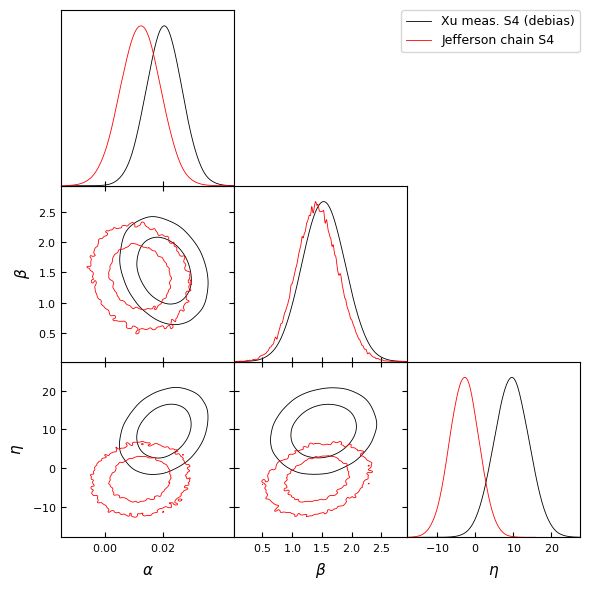

In [291]:
tomo_id = 3
### Plot chains
g = plots.get_subplot_plotter()
g.triangle_plot([mcsamp[tomo_id], mcsamp_Jefferson[tomo_id]])

ms = mcsamp[tomo_id].getMargeStats()
p_alpha = ms.parWithName("alpha")
p_beta = ms.parWithName("beta")
p_eta = ms.parWithName("eta")
print(f'MargeStats: alpha = ({p_alpha.mean*1e3:.2f} \pm {p_alpha.err*1e3:.2f}) x 10^3')
print(f'MargeStats: beta  = ({p_beta.mean:.2f} \pm {p_beta.err:.2f})')
print(f'MargeStats: eta   = ({p_eta.mean:.2f} \pm {p_eta.err:.2f})')

gof = np.min(sample[tomo_id].get_log_prob(flat=True))*-2/(N_dv-N_theta)
print(f'Goodness of fit = {gof:.2f}')

## 3. Generate +2$\sigma$-level Cosmic Shear Contamination

### Contamination from Jefferson et al. (2025)

+2sigma contamination dchi2 = 2.5348329146816986


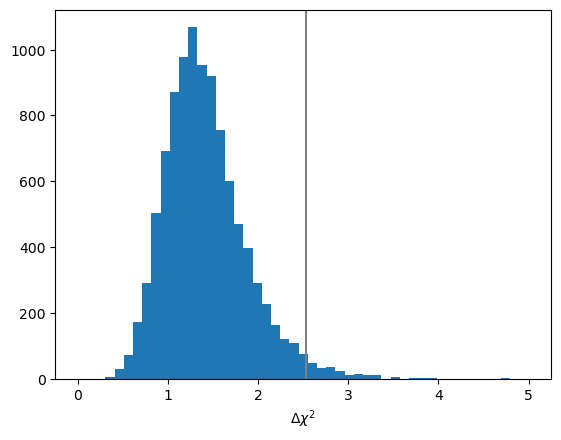

In [275]:
# get an MCMC sample & generate dxipm from them
Nsteps = taus['tau_statistics']['chain_bestfits_PSF-reserved']['bin_0']['alpha'][:].shape[0]
rand_samp = np.random.choice(Nsteps, 10000, replace=False)
rand_dxipm = []
for idx in rand_samp:
    _alphas = [taus['tau_statistics']['chain_bestfits_PSF-reserved'][f'bin_{k}']['alpha'][idx] 
               for k in range(4)]
    _betas = [taus['tau_statistics']['chain_bestfits_PSF-reserved'][f'bin_{k}']['beta'][idx] 
               for k in range(4)]
    _etas = [taus['tau_statistics']['chain_bestfits_PSF-reserved'][f'bin_{k}']['eta'][idx] 
               for k in range(4)]
    _, _dxipm, _dxipm_err = get_delta_xi_pm_PSF_Jefferson(_alphas, _betas, _etas, [1,1,1,1])
    rand_dxipm.append(_dxipm)
    
### dchi2 for those random samples
dchi2_random_samp_Jefferson = np.zeros(len(rand_dxipm))
dxi_pm_interp_sample_Jefferson = []
for i in range(len(rand_dxipm)):
    # interpolate the Jefferson+ binning into our own
    dxi_pm_interp = np.zeros(len(thetas)*20)
    for j in range(20):
        y_jef_grid = rand_dxipm[i][j*20:(j+1)*20]
        dxi_pm_interp[j*30:(j+1)*30] = np.interp(np.log10(thetas), np.log10(thetas_jef), y_jef_grid)
    dchi2_random_samp_Jefferson[i] = dxi_pm_interp@invcov@dxi_pm_interp
    dxi_pm_interp_sample_Jefferson.append(dxi_pm_interp)
# show the dchi2 distribution
plt.hist(dchi2_random_samp_Jefferson, bins=np.linspace(0,5,50))
plt.xlabel(r'$\Delta \chi^2$')
# pick the +2sigma sample
sorted_idx = np.argsort(dchi2_random_samp_Jefferson)
p2sigma_id = sorted_idx[int(len(sorted_idx)*0.977)]
p2sigma_dchi2_Jefferson = dchi2_random_samp_Jefferson[p2sigma_id]
p2sigma_dxipm_Jefferson = dxi_pm_interp_sample_Jefferson[p2sigma_id]
print(f'+2sigma contamination dchi2 = {p2sigma_dchi2_Jefferson}')
plt.axvline(p2sigma_dchi2_Jefferson, ls='-', color='grey')
plt.show()

$\Delta \chi^2$ = 2.5851352857103573 

### Contamination from Xu measurement

+2sigma contamination dchi2 = 2.3870256862023522


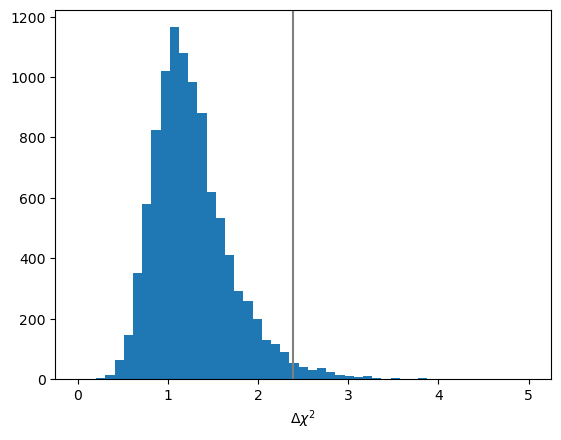

In [277]:
# get an MCMC sample & generate dxipm from them
_samples_tomo = [sample[tomo_id].get_chain(flat=True, thin=4) for tomo_id in range(4)]
Nsteps = _samples_tomo[0].shape[0]
rand_samp = np.random.choice(Nsteps, 10000, replace=False)
rand_dxipm_Xu = []
for idx in rand_samp:
    _alphas = [_samples_tomo[k][idx,0] for k in range(4)]
    _betas = [_samples_tomo[k][idx,1] for k in range(4)]
    _etas = [_samples_tomo[k][idx,2] for k in range(4)]
    _dxipm, _dxipm_err = get_delta_xi_pm_PSF(_alphas, _betas, _etas, rho_riz_stats, [1,1,1,1])
    rand_dxipm_Xu.append(_dxipm)
    
### dchi2 for those random samples
dchi2_random_samp_Xu = np.zeros(len(rand_dxipm_Xu))
for i in range(len(rand_dxipm_Xu)):
    dchi2_random_samp_Xu[i] = rand_dxipm_Xu[i]@invcov@rand_dxipm_Xu[i]
# show the dchi2 distribution
plt.hist(dchi2_random_samp_Xu, bins=np.linspace(0,5,50))
plt.xlabel(r'$\Delta \chi^2$')
# pick the +2sigma sample
sorted_idx = np.argsort(dchi2_random_samp_Xu)
p2sigma_id = sorted_idx[int(len(sorted_idx)*0.977)]
p2sigma_dchi2_Xu = dchi2_random_samp_Xu[p2sigma_id]
p2sigma_dxipm_Xu = rand_dxipm_Xu[p2sigma_id]
print(f'+2sigma contamination dchi2 = {p2sigma_dchi2_Xu}')
plt.axvline(p2sigma_dchi2_Xu, ls='-', color='grey')
plt.show()

$\Delta \chi^2$ = 2.3870256862023522

Ndata = 20


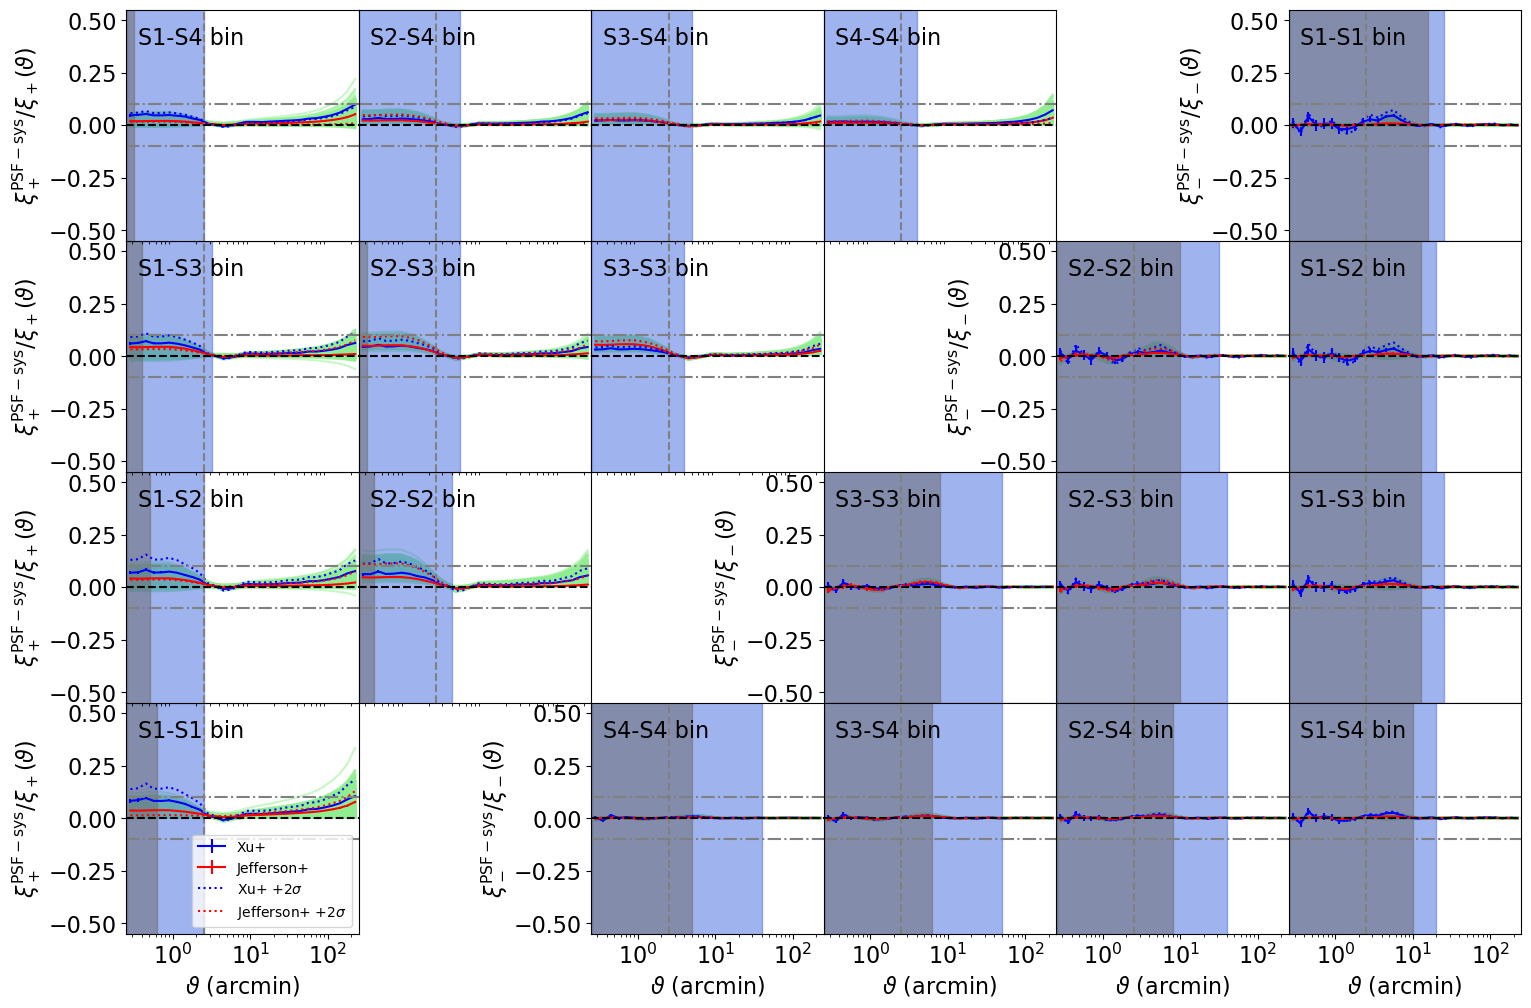

In [278]:
fig = plt.figure(figsize=(18, 12))

use_real_data = False

ct = 0
lines = []

### get the delta xi_pm
# coeff: mine+; rhos: mine
dxipm_Xu, dxipm_err_Xu = get_delta_xi_pm_PSF(alphas_Xu, betas_Xu, etas_Xu, 
                                                           rho_riz_stats, [1,1,1,1])
# coeff: Amon+l rhos: mine
alphas_Amon = [0.010, -0.001, -0.004, 0.014]
betas_Amon = [0.6, 1.4, 2.5, 1.3]
etas_Amon = [-4.6, -4.5, 3.0, 4.2]
dxipm_Amon, dxipm_err_Amon = get_delta_xi_pm_PSF(alphas_Amon, betas_Amon, etas_Amon, 
                                                           rho_riz_stats, [1,1,1,1])
# coeff: Jefferson+; rhos: Jefferson+
alphas_Jefferson = [9.10e-3, 4.31e-3, 3.5e-3, 1.23e-3]
betas_Jefferson = [0.491, 1.84, 2.4, 1.42]
etas_Jefferson = [-2.31, -5.55, 1.54, -2.86]
thetas_Jefferson, dxipm_Jefferson, dxipm_err_Jefferson = get_delta_xi_pm_PSF_Jefferson(
    alphas_Jefferson, betas_Jefferson, etas_Jefferson, [1,1,1,1])

dxipm_jef_interp = np.zeros(600) # best-fit contamination

### get a reference data vector and mask
baseline_mask = np.genfromtxt(os.path.join(TARGET_DIR,
                    "xi_DESY3xPLKR4_6x2pt_Maglim_baseline_Ntheta30_candidate10_v2.mask"))
Y3_mask = np.genfromtxt(os.path.join(TARGET_DIR,
                    "xi_DESY3xPLKR4_6x2pt_Maglim_baseline_Ntheta30_Y3aggr.mask"))
# baseline_dv = np.genfromtxt(os.path.join(TARGET_DIR,
#                     "xi_DESY3xPLKR4_6x2pt_Maglim_baseline_Ntheta30_PubY3bestfit3x2ptNLA_HF.simudata"))[:600,1]
baseline_dv = np.genfromtxt(os.path.join(TARGET_DIR,
                    "xi_DESY3_cosmic_shear_Ntheta30_JeffersonFiducial_T7.8.simudata"))[:600,1]

### show shear-shear xi+
for i in range(4):
    for j in range(i,4):
        ax = plt.subplot2grid((4, 6), (3-j, i))
        ax.text(0.05,0.85,'S%d-S%d bin'%(i+1, j+1),transform=ax.transAxes, fontsize=16)
        
        ### Read Real Measurements
        if use_real_data:
            xi_s = np.genfromtxt(os.path.join(TARGET_DIR, "shear_small-scale_withIm_%d_%d.txt"%(i,j)), names=True)
            xi_l = np.genfromtxt(os.path.join(TARGET_DIR, "shear_withIm_%d_%d.txt"%(i,j)), names=True)
            r = np.hstack([xi_s['r'], xi_l['r']])
            xi = np.hstack([xi_s['xip'], xi_l['xip']])
            xivar = np.hstack([xi_s["varxip"], xi_l["varxip"]])
        else:
            xi = baseline_dv[ct*30:(ct+1)*30]
            xivar = np.zeros(30)
            r = thetas
        ### Plot PSF contaminations
        # data vector
        y_Amon = dxipm_Amon[ct*30:(ct+1)*30]; yerr_Amon=dxipm_err_Amon[ct*30:(ct+1)*30]
        y_Xu = dxipm_Xu[ct*30:(ct+1)*30]; yerr_Xu=dxipm_err_Xu[ct*30:(ct+1)*30]
        y_2sigma_Xu = p2sigma_dxipm_Xu[ct*30:(ct+1)*30]
        y_jef_grid = dxipm_jef[ct*20:(ct+1)*20]; yerr_jef_grid = dxipm_err_jef[ct*20:(ct+1)*20]
        y_jef = np.interp(np.log10(r), np.log10(thetas_jef), y_jef_grid)
        yerr_jef = np.interp(np.log10(r), np.log10(thetas_jef), yerr_jef_grid)
        dxipm_jef_interp[ct*30:(ct+1)*30] = yerr_jef
        y_2sigma_jef = p2sigma_dxipm_Jefferson[ct*30:(ct+1)*30]
        
        # data vector ratio error
        ratio_err_Amon = np.abs(y_Amon/xi)*np.sqrt(xivar/xi**2 + (yerr_Amon/y_Amon)**2)
        ratio_err_Xu = np.abs(y_Xu/xi)*np.sqrt(xivar/xi**2 + (yerr_Xu/y_Xu)**2)
        ratio_err_jef = np.abs(y_jef/xi)*np.sqrt(xivar/xi**2 + (yerr_jef/y_jef)**2)
        
        _l2 = ax.errorbar(r, y_Xu/xi, yerr=ratio_err_Xu, color='blue', ls='-', 
                          label=r'Xu+', zorder=1)
        _l3 = ax.errorbar(r, y_jef/xi, yerr=ratio_err_jef, color='red', ls='-',
                          label=r'Jefferson+', zorder=1)
        _l4 = ax.errorbar(r, y_2sigma_Xu/xi, color='blue', ls=':',
                          label=r'Xu+ $+2\sigma$', zorder=1)
        _l5 = ax.errorbar(r, y_2sigma_jef/xi, color='red', ls=':',
                          label=r'Jefferson+ $+2\sigma$', zorder=1)
#         ax.fill_between([0,300], -0.1, 0.1, color='grey', alpha=0.5)
        ax.axhline(-0.1, color='grey', ls='-.')
        ax.axhline(0.1, color='grey', ls='-.')
        
        # MCMC sample
        for _dxipm in dxi_pm_interp_sample[::10]:
            ax.plot(r, _dxipm[ct*30:(ct+1)*30]/xi, color='lightgreen', ls='-', alpha=0.5, zorder=0)
            
        ### annotate masks
        ax.axvline(2.5, color='grey', ls='--')
        for m,c in zip([Y3_mask, baseline_mask], ['royalblue', 'dimgrey']):
            _m = np.where(m[ct*30:(ct+1)*30]<0.5)[0]
            _x = r[_m]
            if len(_x)>0:
                if len(_x)==1:
                    _x = [_x[0], _x[0]]
                _x[-1] *= 1.12
                _x[0] /= 1.12
                ax.fill_between(_x, -10, 10, color=c, zorder=0, alpha=0.5)
        
        ### Plot customization
        ax.set(xscale='log')
        ax.tick_params(axis='both', which='major', labelsize=16)
        if (i==0):
            ax.set_ylabel(r'$\xi^\mathrm{PSF-sys}_+/\xi_+(\vartheta)$', fontsize=16)
        else:
            ax.set_yticks([])
        if (j==0):
            ax.set_xlabel(r'$\vartheta$ (arcmin)', fontsize=16)
        else:
            ax.set_xticks([])
        ax.set_ylim([-0.55,0.55])
        ax.set_xlim([0.25, 250])
        ax.axhline(0, ls='--', color='k')
        ct += 1
        if (i==j==0):
            ax.legend(loc='lower right')
### show shear-shear xi-
for i in range(4):
    for j in range(i,4):
        ax = plt.subplot2grid((4, 6), (j, 5-i))
        ax.text(0.05,0.85,'S%d-S%d bin'%(i+1, j+1),transform=ax.transAxes, fontsize=16)
        
        ### Read Real Measurements
        if use_real_data:
            xi_s = np.genfromtxt(os.path.join(TARGET_DIR, "shear_small-scale_%d_%d.txt"%(i,j)), names=True)
            xi_l = np.genfromtxt(os.path.join(TARGET_DIR, "shear_%d_%d.txt"%(i,j)), names=True)
            r = np.hstack([xi_s['r'], xi_l['r']])
            xi = np.hstack([xi_s['xim'], xi_l['xim']])
            xivar = np.hstack([xi_s["varxim"], xi_l["varxim"]])
        else:
            xi = baseline_dv[ct*30:(ct+1)*30]
            xivar = np.zeros(30)
            r = thetas
        ### Plot PSF contaminations
        y_Amon = dxipm_Amon[ct*30:(ct+1)*30]; yerr_Amon=dxipm_err_Amon[ct*30:(ct+1)*30]
        y_Xu = dxipm_Xu[ct*30:(ct+1)*30]; yerr_Xu=dxipm_err_Xu[ct*30:(ct+1)*30]
        y_2sigma_Xu = p2sigma_dxipm_Xu[ct*30:(ct+1)*30]
        y_jef_grid = dxipm_jef[ct*20:(ct+1)*20]; yerr_jef_grid = dxipm_err_jef[ct*20:(ct+1)*20]
        y_jef = np.interp(np.log10(r), np.log10(thetas_jef), y_jef_grid)
        yerr_jef = np.interp(np.log10(r), np.log10(thetas_jef), yerr_jef_grid)
        dxipm_jef_interp[ct*30:(ct+1)*30] = yerr_jef
        y_2sigma_jef = p2sigma_dxipm_Jefferson[ct*30:(ct+1)*30]
        
        # data vector ratio error
        ratio_err_Amon = np.abs(y_Amon/xi)*np.sqrt(xivar/xi**2 + (yerr_Amon/y_Amon)**2)
        ratio_err_Xu = np.abs(y_Xu/xi)*np.sqrt(xivar/xi**2 + (yerr_Xu/y_Xu)**2)
        ratio_err_jef = np.abs(y_jef/xi)*np.sqrt(xivar/xi**2 + (yerr_jef/y_jef)**2)
        
        ax.errorbar(r, y_Xu/xi, yerr=ratio_err_Xu, color='blue', ls='-', zorder=1)
        ax.errorbar(r, y_jef/xi, yerr=ratio_err_jef, color='red', ls='-', zorder=1)
        ax.errorbar(r, y_2sigma_Xu/xi, color='blue', ls=':', zorder=1)
        ax.errorbar(r, y_2sigma_jef/xi, color='red', ls=':', zorder=1)
        ax.axhline(-0.1, color='grey', ls='-.')
        ax.axhline(0.1, color='grey', ls='-.')
        
        # MCMC sample
        for _dxipm in dxi_pm_interp_sample[::10]:
            ax.plot(r, _dxipm[ct*30:(ct+1)*30]/xi, color='lightgreen', ls='-', alpha=0.5, zorder=0)
        
        ### annotate masks
        ax.axvline(2.5, color='grey', ls='--')
        for m,c in zip([Y3_mask, baseline_mask], ['royalblue', 'dimgrey']):
            _m = np.where(m[ct*30:(ct+1)*30]<0.5)[0]
            _x = r[_m]
            if len(_x)>0:
                if len(_x)==1:
                    _x = [_x[0], _x[0]]
                _x[-1] *= 1.12
                _x[0] /= 1.12
                ax.fill_between(_x, -10, 10, color=c, zorder=0, alpha=0.5)
        
        ### Plot customization
        ax.set(xscale='log')
        if(i==j):
            ax.set_ylabel(r'$\xi^\mathrm{PSF-sys}_-/\xi_-(\vartheta)$', fontsize=16)
            ax.tick_params(axis='y', which='major', labelsize=16)
        else:
            ax.set_yticks([])
        if(j==3):
            ax.set_xlabel(r'$\vartheta$ (arcmin)', fontsize=16)
            ax.tick_params(axis='x', which='major', labelsize=16)
        else:
            ax.set_xticks([])
        ax.set_ylim([-0.55,0.55])
        ax.set_xlim([0.25, 250])
        ax.axhline(0, ls='--', color='k')
        ct += 1
        

print("Ndata = {}".format(ct))
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
#plt.savefig('figs/Y3_xipm_Ntheta30_additive_bias_ratio_Amon_Jefferson_v2.png', 
#            dpi=300, transparent=False, facecolor="white")

## 4. Save Contaminations

In [279]:
np.savetxt("delta_xi_pm_PSF_contamination_Jefferson_p2sigma_interp.txt", p2sigma_dxipm_Jefferson)
np.savetxt("delta_xi_pm_PSF_contamination_Jefferson_bestfit_interp.txt", dxipm_jef_interp)
np.savetxt("delta_xi_pm_PSF_contamination_Xu_p2sigma_interp.txt", p2sigma_dxipm_Xu)
np.savetxt("delta_xi_pm_PSF_contamination_Xu_bestfit_interp.txt", dxipm_Xu)